# Camada Prata - Transformação dos Dados dos terremotos



In [0]:
# Importes necessários

import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql.functions import from_unixtime, col, year, month
from pyspark.sql.functions import col, isnan, when, count, isnull
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
import pandas as pd
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
import time
from pyspark.sql.functions import to_date




In [0]:
# Caminho do arquivo Delta Lake
file_path = "/mnt/dados/camada_bronze_terremotos"

# Ler o arquivo Delta Lake
df = spark.read.format("delta").load(file_path)

# Visualizar as primeiras 5 linhas do DataFrame
df.show(2)


+-------+----------+--------------+--------------------+---------------+------------------+--------------------+--------------------+---------------+--------------+--------------+----------------+-----------------+------------------+--------------+--------------+---------------+--------------------+------------------+--------------------+--------------+---------------+--------------+-----------------+------------------+---------------+--------------------+-------------+--------------------+
|   type|        id|properties.mag|    properties.place|properties.time|properties.updated|      properties.url|   properties.detail|properties.felt|properties.cdi|properties.mmi|properties.alert|properties.status|properties.tsunami|properties.sig|properties.net|properties.code|      properties.ids|properties.sources|    properties.types|properties.nst|properties.dmin|properties.rms|   properties.gap|properties.magType|properties.type|    properties.title|geometry.type|geometry.coordinates|
+-------

**Análise dos dados recebidos**

Quantas linhas foram recebidas?

In [0]:
df.count()

Out[3]: 399

Como é o formato da tabela? Quais colunas foram fornecidas?

In [0]:


df.printSchema()



root
 |-- type: string (nullable = true)
 |-- id: string (nullable = true)
 |-- properties.mag: double (nullable = true)
 |-- properties.place: string (nullable = true)
 |-- properties.time: long (nullable = true)
 |-- properties.updated: long (nullable = true)
 |-- properties.url: string (nullable = true)
 |-- properties.detail: string (nullable = true)
 |-- properties.felt: double (nullable = true)
 |-- properties.cdi: double (nullable = true)
 |-- properties.mmi: double (nullable = true)
 |-- properties.alert: string (nullable = true)
 |-- properties.status: string (nullable = true)
 |-- properties.tsunami: long (nullable = true)
 |-- properties.sig: long (nullable = true)
 |-- properties.net: string (nullable = true)
 |-- properties.code: string (nullable = true)
 |-- properties.ids: string (nullable = true)
 |-- properties.sources: string (nullable = true)
 |-- properties.types: string (nullable = true)
 |-- properties.nst: double (nullable = true)
 |-- properties.dmin: double (nu

dicionário dos dados: https://earthquake.usgs.gov/data/comcat/index.php#event-terms

A Análise do dicionário dos dados mostra que as seguintes variáveis são de interesse para nossa pesquisa no momento:


 
 |-- id: string (nullable = true) ### A unique identifier for the event. This is the current preferred id for the event, and may change over time.

 |-- properties.mag: double (nullable = true) ### The magnitude for the event.

 |-- properties.time: long (nullable = true) ### Time when the event occurred. 

 |-- properties.url: string (nullable = true) ### Link to USGS Event Page for event.

 |-- properties.sig: long (nullable = true) ### A number describing how significant the event is. Larger numbers indicate a more significant event. 
 
 |-- properties.magType: string (nullable = true) ### The method or algorithm used to calculate the preferred magnitude for the event.

 |-- properties.type: string (nullable = true) ### Type of seismic event.
 
 |-- geometry.type: string (nullable = true)   ### Ponto de referência?
 |-- geometry.coordinates: array (nullable = true)  ### Coordenadas
 |    |-- element: double (containsNull = true)


esse formato properties.mag, properties.place etc traz algumas dificuldades e erros. Vamos primeiro renomear todas as colunas:

In [0]:
# Renomear colunas
df_renamed = df.withColumnRenamed("properties.mag", "prop_mag") \
               .withColumnRenamed("properties.place", "prop_place") \
               .withColumnRenamed("properties.time", "prop_time") \
               .withColumnRenamed("properties.updated", "prop_updated") \
               .withColumnRenamed("properties.url", "prop_url") \
               .withColumnRenamed("properties.detail", "prop_detail") \
               .withColumnRenamed("properties.felt", "prop_felt") \
               .withColumnRenamed("properties.cdi", "prop_cdi") \
               .withColumnRenamed("properties.mmi", "prop_mmi") \
               .withColumnRenamed("properties.alert", "prop_alert") \
               .withColumnRenamed("properties.status", "prop_status") \
               .withColumnRenamed("properties.tsunami", "prop_tsunami") \
               .withColumnRenamed("properties.sig", "prop_sig") \
               .withColumnRenamed("properties.net", "prop_net") \
               .withColumnRenamed("properties.code", "prop_code") \
               .withColumnRenamed("properties.ids", "prop_ids") \
               .withColumnRenamed("properties.sources", "prop_sources") \
               .withColumnRenamed("properties.types", "prop_types") \
               .withColumnRenamed("properties.nst", "prop_nst") \
               .withColumnRenamed("properties.dmin", "prop_dmin") \
               .withColumnRenamed("properties.rms", "prop_rms") \
               .withColumnRenamed("properties.gap", "prop_gap") \
               .withColumnRenamed("properties.magType", "prop_magType") \
               .withColumnRenamed("properties.type", "prop_type") \
               .withColumnRenamed("properties.title", "prop_title") \
               .withColumnRenamed("geometry.type", "geometry_type") \
               .withColumnRenamed("geometry.coordinates", "geometry_coordinates")

df = df_renamed

# Verificar o novo esquema
df.printSchema()


root
 |-- type: string (nullable = true)
 |-- id: string (nullable = true)
 |-- prop_mag: double (nullable = true)
 |-- prop_place: string (nullable = true)
 |-- prop_time: long (nullable = true)
 |-- prop_updated: long (nullable = true)
 |-- prop_url: string (nullable = true)
 |-- prop_detail: string (nullable = true)
 |-- prop_felt: double (nullable = true)
 |-- prop_cdi: double (nullable = true)
 |-- prop_mmi: double (nullable = true)
 |-- prop_alert: string (nullable = true)
 |-- prop_status: string (nullable = true)
 |-- prop_tsunami: long (nullable = true)
 |-- prop_sig: long (nullable = true)
 |-- prop_net: string (nullable = true)
 |-- prop_code: string (nullable = true)
 |-- prop_ids: string (nullable = true)
 |-- prop_sources: string (nullable = true)
 |-- prop_types: string (nullable = true)
 |-- prop_nst: double (nullable = true)
 |-- prop_dmin: double (nullable = true)
 |-- prop_rms: double (nullable = true)
 |-- prop_gap: double (nullable = true)
 |-- prop_magType: string

e agora eliminar aquelas de que não precisamos

In [0]:
# Selecionar apenas as colunas desejadas
df_selected = df.select(
    "id",
    "prop_mag",
    "prop_time",
    "prop_url",
    "prop_sig",
    "prop_magType",
    "prop_type",
    "geometry_type",
    "geometry_coordinates"
)
df = df_selected

# Verificar o novo esquema
df.printSchema()


root
 |-- id: string (nullable = true)
 |-- prop_mag: double (nullable = true)
 |-- prop_time: long (nullable = true)
 |-- prop_url: string (nullable = true)
 |-- prop_sig: long (nullable = true)
 |-- prop_magType: string (nullable = true)
 |-- prop_type: string (nullable = true)
 |-- geometry_type: string (nullable = true)
 |-- geometry_coordinates: array (nullable = true)
 |    |-- element: double (containsNull = true)



**Analisando a coluna id**

In [0]:
df.select('id').describe().show() 

+-------+----------+
|summary|        id|
+-------+----------+
|  count|       399|
|   mean|      null|
| stddev|      null|
|    min|at00sthakw|
|    max|usp000jta1|
+-------+----------+



In [0]:

# Contar valores nulos
null_count = df.filter(col("id").isNull()).count()
print(f"Número de valores nulos na coluna 'id': {null_count}")


Número de valores nulos na coluna 'id': 0


In [0]:
# Contar valores em branco
blank_count = df.filter(col("id") == "").count()
print(f"Número de valores em branco na coluna 'id': {blank_count}")


Número de valores em branco na coluna 'id': 0


In [0]:
# Contar valores duplicados
duplicate_count = df.groupBy("id").count().filter("count > 1").count()
print(f"Número de valores duplicados na coluna 'id': {duplicate_count}")


Número de valores duplicados na coluna 'id': 0


Conclusão: id é uma ótima **chave-primária** de fato: sem valores nulos ou em branco ou repetidos. Vamos de qualquer forma ordenar a eliminação de valores nulos, em branco ou repetidos, caso este problema aconteça em futuras leituras da API do USGS.

In [0]:
df = df.filter(df["id"].isNotNull())
df = df.filter(df["id"] != "")
df = df.dropDuplicates(["id"])
df.count() ### O resultado da contagem deve ser igual à contagem anterior, evidenciando que não havia valores nulos, em branco ou duplicados.

Out[11]: 399

**Analisando a coluna prop_mag**

In [0]:
df.select('prop_mag').describe().show() 


+-------+------------------+
|summary|          prop_mag|
+-------+------------------+
|  count|               399|
|   mean| 5.404260651629068|
| stddev|0.4709734303451008|
|    min|               5.0|
|    max|               7.8|
+-------+------------------+



Out[13]: [Text(0.5, 1.0, 'Histograma dos valores de properties.mag'),
 Text(0.5, 0, 'Magnitude'),
 Text(0, 0.5, 'Frequência')]

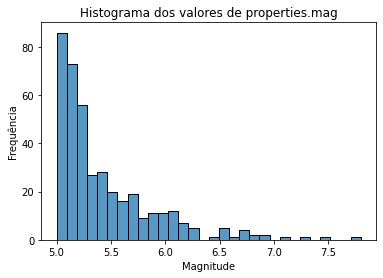

In [0]:
# Extrair os valores da coluna 'prop_mag'
mag_values = df.select("prop_mag").rdd.flatMap(lambda x: x).collect()

# Plotar o histograma usando seaborn
sns.histplot(mag_values, bins=30, kde=False).set(title='Histograma dos valores de properties.mag', xlabel='Magnitude', ylabel='Frequência')


**Analisando magType**

In [0]:
df.select('prop_magType').describe().show()

+-------+------------+
|summary|prop_magType|
+-------+------------+
|  count|         399|
|   mean|        null|
| stddev|        null|
|    min|          Mi|
|    max|         mww|
+-------+------------+



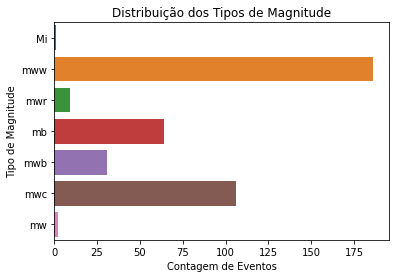

In [0]:

# Converter para Pandas DataFrame para visualização
pdf = df.select("prop_magType").toPandas()

# Plotar o histograma da coluna magType com categorias na vertical e barras horizontais
sns.countplot(y='prop_magType', data=pdf)
plt.title('Distribuição dos Tipos de Magnitude')
plt.xlabel('Contagem de Eventos')
plt.ylabel('Tipo de Magnitude')
plt.show()


https://www.usgs.gov/programs/earthquake-hazards/magnitude-types


**Analisando a coluna prop_time**

In [0]:
# Calcular estatísticas descritivas para a coluna de tempo
df.describe("prop_time").show()


+-------+--------------------+
|summary|           prop_time|
+-------+--------------------+
|  count|                 399|
|   mean|1.425577777969837...|
| stddev|1.917314939694194...|
|    min|       1106281829010|
|    max|       1742568656000|
+-------+--------------------+



esse formato de tempo não é amigável. Vamos corrigir isso.

In [0]:
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY") #definindo como fazer o "parse"

# Converter o tempo de milissegundos para um formato de data legível
df_com_data = df.withColumn("data", to_date(from_unixtime(col("prop_time") / 1000), "yyyy-MM-dd"))
df = df_com_data

# Deletando a coluna prop_time
df = df.drop("prop_time") # Não vamos mais usar.

# Verificar o novo esquema
df.printSchema()




root
 |-- id: string (nullable = true)
 |-- prop_mag: double (nullable = true)
 |-- prop_url: string (nullable = true)
 |-- prop_sig: long (nullable = true)
 |-- prop_magType: string (nullable = true)
 |-- prop_type: string (nullable = true)
 |-- geometry_type: string (nullable = true)
 |-- geometry_coordinates: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- data: date (nullable = true)



In [0]:
# Mostrar algumas linhas do DataFrame resultante
df.head(5)

Out[18]: [Row(id='at00sthakw', prop_mag=6.5, prop_url='https://earthquake.usgs.gov/earthquakes/eventpage/at00sthakw', prop_sig=650, prop_magType='Mi', prop_type='earthquake', geometry_type='Point', geometry_coordinates=[-82.3, 7.2, 10.0], data=datetime.date(2025, 3, 21)),
 Row(id='us10001ldx', prop_mag=6.2, prop_url='https://earthquake.usgs.gov/earthquakes/eventpage/us10001ldx', prop_sig=842, prop_magType='mww', prop_type='earthquake', geometry_type='Point', geometry_coordinates=[-72.9875, 6.7757, 155.0], data=datetime.date(2015, 3, 10)),
 Row(id='us10001pn4', prop_mag=5.1, prop_url='https://earthquake.usgs.gov/earthquakes/eventpage/us10001pn4', prop_sig=418, prop_magType='mwr', prop_type='earthquake', geometry_type='Point', geometry_coordinates=[-73.147, 6.804, 154.6], data=datetime.date(2015, 3, 22)),
 Row(id='us10001rcr', prop_mag=5.5, prop_url='https://earthquake.usgs.gov/earthquakes/eventpage/us10001rcr', prop_sig=468, prop_magType='mww', prop_type='earthquake', geometry_type='Poi

ótimo, agora temos dados legíveis sobre o momento de ocorrência dos terremotos.

In [0]:
# Contar valores nulos
null_count = df.filter(col("data").isNull()).count()
print(f"Número de valores nulos na coluna 'data': {null_count}")

# Contar valores em branco
blank_count = df.filter(col("data") == "").count()
print(f"Número de valores em branco na coluna 'data': {blank_count}")


Número de valores nulos na coluna 'data': 0
Número de valores em branco na coluna 'data': 0


In [0]:
df.count()

Out[20]: 399

In [0]:
df = df.filter(df["data"].isNotNull())

df.count() ### O resultado da contagem deve ser igual à contagem anterior, evidenciando que não havia valores nulos.

Out[21]: 399

**Analisando a coluna sig**

In [0]:
df.select('prop_sig').describe().show() 

+-------+------------------+
|summary|          prop_sig|
+-------+------------------+
|  count|               399|
|   mean|478.83709273182956|
| stddev|132.63004816386314|
|    min|               385|
|    max|              1292|
+-------+------------------+



Out[23]: [Text(0.5, 1.0, 'Histograma dos valores de prop_sig'),
 Text(0.5, 0, 'Significância'),
 Text(0, 0.5, 'Frequência')]

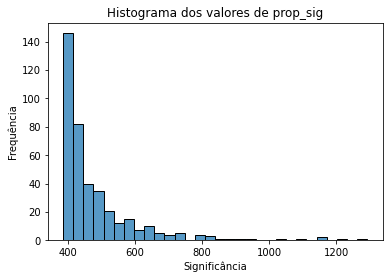

In [0]:
# Extrair os valores da coluna 'prop_mag'
sig_values = df.select("prop_sig").rdd.flatMap(lambda x: x).collect()

# Plotar o histograma usando seaborn
sns.histplot(sig_values, bins=30, kde=False).set(title='Histograma dos valores de prop_sig', xlabel='Significância', ylabel='Frequência')

Comparando Mag e Sig

Correlação entre prop_mag e prop_sig: 0.858571202916535


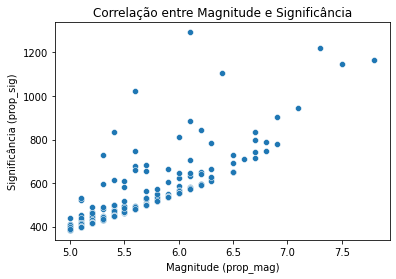

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql.functions import col

# Selecionar as colunas prop_mag e prop_sig
df_selected = df.select(col("prop_mag"), col("prop_sig"))

# Converter para Pandas DataFrame para visualização e cálculo de correlação
pdf_selected = df_selected.toPandas()

# Calcular a correlação entre prop_mag e prop_sig
correlation = pdf_selected['prop_mag'].corr(pdf_selected['prop_sig'])
print(f"Correlação entre prop_mag e prop_sig: {correlation}")

# Plotar a correlação usando Seaborn
sns.scatterplot(x='prop_mag', y='prop_sig', data=pdf_selected)
plt.title('Correlação entre Magnitude e Significância')
plt.xlabel('Magnitude (prop_mag)')
plt.ylabel('Significância (prop_sig)')
plt.show()


Como existe uma alta correlação entre Mag e Sig, porém Sig é afetado por outros fatores além da energia liberada, vamos utilizar Mag. Apesar de existirem diferentes métodos para cálculo de Mag, no final todos representam o mesmo conceito (energia liberada) e utilizam a mesma unidade de medida.

In [0]:
df = df.drop("prop_sig")
df = df.drop("prop_magType") ### Também não vamos precisar disto para esta análise
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- prop_mag: double (nullable = true)
 |-- prop_url: string (nullable = true)
 |-- prop_type: string (nullable = true)
 |-- geometry_type: string (nullable = true)
 |-- geometry_coordinates: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- data: date (nullable = true)



**Analisando prop_type**

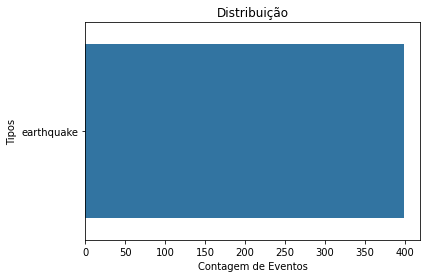

In [0]:
# Converter para Pandas DataFrame para visualização
pdf = df.select("prop_type").toPandas()

# Plotar o histograma da coluna prop_type com categorias na vertical e barras horizontais
sns.countplot(y='prop_type', data=pdf)
plt.title('Distribuição')
plt.xlabel('Contagem de Eventos')
plt.ylabel('Tipos')
plt.show()

só existe 1 tipo de evento, que é earthquake, neste dataset. Vamos implementar um filtro para garantir que não haja outros tipos em consultas futuras, e aí podemos excluir a coluna também.

In [0]:

# Filtrando o DataFrame para manter apenas as linhas onde prop_type é "earthquake"
df_filtered = df.filter(df.prop_type == "earthquake")

# Deletando a coluna prop_type
df = df_filtered.drop("prop_type") # Não vamos usar, mas pelo menos garantimos que nada diferente de earthquake estará em análises futuras.

# Como está o dataset
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- prop_mag: double (nullable = true)
 |-- prop_url: string (nullable = true)
 |-- geometry_type: string (nullable = true)
 |-- geometry_coordinates: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- data: date (nullable = true)



**analisando geometry_type ***


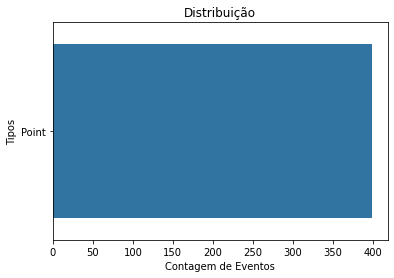

In [0]:
# Converter para Pandas DataFrame para visualização
pdf = df.select("geometry_type").toPandas()

# Plotar o histograma da coluna geometry_type com categorias na vertical e barras horizontais
sns.countplot(y='geometry_type', data=pdf)
plt.title('Distribuição')
plt.xlabel('Contagem de Eventos')
plt.ylabel('Tipos')
plt.show()

In [0]:
## Seguindo a mesma estratégia anterior, vamos garantir que só haja geometry_type == "Point"
# Filtrando o DataFrame para manter apenas as linhas onde geomatry_type é "Point"
df_filtered = df.filter(df.geometry_type == "Point")

# Deletando a coluna geometry_type
df = df_filtered.drop("geometry_type") # Não vamos usar, mas pelo menos garantimos que nada diferente de Point estará em análises futuras.

# Como está o dataset
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- prop_mag: double (nullable = true)
 |-- prop_url: string (nullable = true)
 |-- geometry_coordinates: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- data: date (nullable = true)



**Finalmente analisando coordenadas**

In [0]:
df.select("geometry_coordinates").head(10)

Out[30]: [Row(geometry_coordinates=[-82.3, 7.2, 10.0]),
 Row(geometry_coordinates=[-72.9875, 6.7757, 155.0]),
 Row(geometry_coordinates=[-73.147, 6.804, 154.6]),
 Row(geometry_coordinates=[-77.5836, -1.2012, 195.03]),
 Row(geometry_coordinates=[-77.5501, -3.0826, 8.45]),
 Row(geometry_coordinates=[-82.6431, 5.18, 10.0]),
 Row(geometry_coordinates=[-77.476, 7.5362, 10.0]),
 Row(geometry_coordinates=[-73.3038, 7.6522, 125.68]),
 Row(geometry_coordinates=[-78.7623, -2.5015, 97.13]),
 Row(geometry_coordinates=[-71.3957, 8.4672, 15.12])]

Observamos que a informação vem como um vetor de 3 dígitos: longitude, latitude e profundidade. Para nossa análise não usaremos profundidade, assim podemos descartá-la. Além disso, será melhor termos latitude e longitude como colunas independentes. Isso vai facilitar as análises no futuro.

In [0]:

# Criando as novas colunas latitude e longitude a partir da coluna geometry_coordinates
df_com_coordenadas = df.withColumn("latitude", col("geometry_coordinates")[1])
df_com_coordenadas = df_com_coordenadas.withColumn("longitude", col("geometry_coordinates")[0])
df_com_coordenadas.printSchema()

root
 |-- id: string (nullable = true)
 |-- prop_mag: double (nullable = true)
 |-- prop_url: string (nullable = true)
 |-- geometry_coordinates: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- data: date (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)



In [0]:
# Deletando a coluna geometry_coordinates
df = df_com_coordenadas.drop("geometry_coordinates") 

Determinando o país onde está o epicentro do terremoto

In [0]:
# Converter o DataFrame Spark para Pandas
df_pandas = df.toPandas()

# Inicializar o geocodificador
geolocator = Nominatim(user_agent="DataBricksCommunityEdition")

# Realizar a geocodificação usando Pandas
def reverse_geocode(lat, lon):
    try:
        time.sleep(1)
        location = geolocator.reverse((lat, lon))
        if location and "country" in location.raw["address"]:
            return location.raw["address"]["country"]
        return "Desconhecido"
    except Exception:
        return "Erro"

# Aplicar a função ao DataFrame Pandas
df_pandas["pais"] = df_pandas.apply(lambda row: reverse_geocode(row["latitude"], row["longitude"]), axis=1)

# Converter de volta para PySpark
df = spark.createDataFrame(df_pandas)

# Exibir o DataFrame final no PySpark
df.show()


+----------+--------+--------------------+----------+--------+---------+------------+
|        id|prop_mag|            prop_url|      data|latitude|longitude|        pais|
+----------+--------+--------------------+----------+--------+---------+------------+
|at00sthakw|     6.5|https://earthquak...|2025-03-21|     7.2|    -82.3|Desconhecido|
|us10001ldx|     6.2|https://earthquak...|2015-03-10|  6.7757| -72.9875|    Colombia|
|us10001pn4|     5.1|https://earthquak...|2015-03-22|   6.804|  -73.147|    Colombia|
|us10001rcr|     5.5|https://earthquak...|2015-03-27| -1.2012| -77.5836|     Ecuador|
|us10002azw|     5.1|https://earthquak...|2015-05-20| -3.0826| -77.5501|        Perú|
|us100030j8|     5.4|https://earthquak...|2015-08-09|    5.18| -82.6431|Desconhecido|
|us10003mxh|     5.2|https://earthquak...|2015-10-12|  7.5362|  -77.476|    Colombia|
|us10003niy|     5.0|https://earthquak...|2015-10-14|  7.6522| -73.3038|    Colombia|
|us10003nud|     5.4|https://earthquak...|2015-10-15| 

Assim ficou nosso dataset refinado.

In [0]:
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- prop_mag: double (nullable = true)
 |-- prop_url: string (nullable = true)
 |-- data: date (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- pais: string (nullable = true)



In [0]:

# Criando um resumo do DataFrame
summary = df.describe()
summary.show()



+-------+----------+-----------------+--------------------+-----------------+------------------+---------+
|summary|        id|         prop_mag|            prop_url|         latitude|         longitude|     pais|
+-------+----------+-----------------+--------------------+-----------------+------------------+---------+
|  count|       399|              399|                 399|              399|               399|      399|
|   mean|      null|5.404260651629072|                null|4.004657644110274|-78.54151052631579|     null|
| stddev|      null|0.470973430345101|                null|3.798890448014465|3.5495313029670807|     null|
|    min|at00sthakw|              5.0|https://earthquak...|           -4.035|            -82.86| Colombia|
|    max|usp000jta1|              7.8|https://earthquak...|          12.2926|          -67.9035|Venezuela|
+-------+----------+-----------------+--------------------+-----------------+------------------+---------+



Este dataset é significativamente diferente do dataset original. Eliminamos colunas desnecessárias, fizemos checagens por dados, em branco ou repetidos (na coluna id, para ser usada como chave primária), convertemos tempo para colunas legíveis, e separamos as coordenadas latitude e longitude, cada uma com sua própria coluna, e até adicionamos colunas com informações extras obtidas por meio de APIs externas. Agora podemos persistir nossos dados como camada prata.

In [0]:

# Caminho para salvar o DataFrame refinado (camada prata)
file_path_silver = "/mnt/dados/camada_prata_terremotos"

# Removendo o diretório existente
dbutils.fs.rm(file_path_silver, recurse=True)

# Salvando o DataFrame refinado no formato Delta Lake (camada prata)
df.write.format("delta").mode("overwrite").save(file_path_silver)
